In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json
/kaggle/input/arxiv-dataset-trimmed/test.json


In [2]:
# import some libraries for NLP and visualize

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Using readlines() 
# test.json is a reduced data set of ../input/arxiv/arxiv-metadata-oai-snapshot.json
file = open('/kaggle/input/arxiv-dataset-trimmed/test.json', 'r') 
Lines = file.readlines() 

In [4]:
len(Lines)

17783

In [5]:
import json 
import time
if __name__ == '__main__':
    start = time.time()
    all_ = []
    for count in range(0,10000):
        current_json = json.loads(Lines[count])
        current_ = [current_json['id'], current_json['categories'], current_json['title']]
        all_.append(current_)
    elapsed_time = time.time() - start
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:0.21059441566467285[sec]


In [6]:
all_df = pd.DataFrame(all_, columns=["id", "categories", "title"])
all_df.head(10)

,id,categories,title
0,0704.0100,gr-qc,Topology Change of Black Holes
1,0704.0200,hep-ph nucl-ex,Electromagnetic polarizabilities and the excit...
2,0704.0300,cond-mat.mes-hall cond-mat.mtrl-sci,Scaling of Resistance and Electron Mean Free P...
3,0704.0400,nlin.SI cond-mat.stat-mech hep-th,The S-Matrix of AdS/CFT and Yangian Symmetry
4,0704.0500,math.GR,On the polynomial automorphisms of a group
5,0704.0600,math.CO math.DS,Solvability of linear equations within weak mi...
6,0704.0700,physics.chem-ph,Detailed kinetic study of the ring opening of ...
7,0704.0800,quant-ph,Quantum Auctions
8,0704.0900,cond-mat.supr-con cond-mat.mes-hall,Voltage-Current curves for small Josephson jun...
9,0704.1000,hep-ex,Measurement of D0-D0bar mixing in D0->Ks pi+ p...


Make 'categories' to more broader 'categories_broad' and encoded it into numerical labels.

In [7]:
import re

all_df['categories_broad'] = all_df['categories']

for ind in all_df.index:
    pos_period = re.search('\.',all_df['categories'][ind].split()[0])
    if pos_period != None:
        all_df['categories_broad'][ind] = re.match('(.*)\.',all_df['categories'][ind].split()[0])[1]
    else:
        all_df['categories_broad'][ind] = all_df['categories'][ind].split()[0]

In [8]:
all_df['categories_broad'].describe()

count     10000
unique       19
top        math
freq       2364
Name: categories_broad, dtype: object

In [16]:
# Encode categories_broad to number
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
all_df['categories_broad_enc'] = le.fit_transform(all_df['categories_broad'])

Using Tensorflow, let's predict the category from the abstract.

In [17]:
sentences = all_df['title'].tolist()
labels = all_df['categories_broad_enc'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [30]:
vocab_size = 1000
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [36]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(19, activation='relu')
])
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
              ,optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 19)                323       
Total params: 16,323
Trainable params: 16,323
Non-trainable params: 0
_________________________________________________________________


In [34]:
num_epochs = 100
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/100
250/250 [==============================] - 0s 2ms/step - loss: 1.4636 - accuracy: 0.6156 - val_loss: 1.6090 - val_accuracy: 0.5840
Epoch 2/100
250/250 [==============================] - 0s 2ms/step - loss: 1.4576 - accuracy: 0.6176 - val_loss: 1.6066 - val_accuracy: 0.5835
Epoch 3/100
250/250 [==============================] - 0s 2ms/step - loss: 1.4516 - accuracy: 0.6198 - val_loss: 1.6118 - val_accuracy: 0.5795
Epoch 4/100
250/250 [==============================] - 0s 2ms/step - loss: 1.4459 - accuracy: 0.6198 - val_loss: 1.6097 - val_accuracy: 0.5820
Epoch 5/100
250/250 [==============================] - 0s 2ms/step - loss: 1.4397 - accuracy: 0.6224 - val_loss: 1.6143 - val_accuracy: 0.5805
Epoch 6/100
250/250 [==============================] - 0s 2ms/step - loss: 1.4347 - accuracy: 0.6219 - val_loss: 1.6028 - val_accuracy: 0.5810
Epoch 7/100
250/250 [==============================] - 0s 2ms/step - loss: 1.4294 - accuracy: 0.6224 - val_loss: 1.6041 - val_accuracy: 0.5840

Epoch 58/100
250/250 [==============================] - 0s 2ms/step - loss: 1.2697 - accuracy: 0.6600 - val_loss: 1.6332 - val_accuracy: 0.5770
Epoch 59/100
250/250 [==============================] - 0s 2ms/step - loss: 1.2681 - accuracy: 0.6621 - val_loss: 1.6337 - val_accuracy: 0.5755
Epoch 60/100
250/250 [==============================] - 0s 2ms/step - loss: 1.2660 - accuracy: 0.6624 - val_loss: 1.6332 - val_accuracy: 0.5775
Epoch 61/100
250/250 [==============================] - 0s 2ms/step - loss: 1.2640 - accuracy: 0.6626 - val_loss: 1.6362 - val_accuracy: 0.5790
Epoch 62/100
250/250 [==============================] - 0s 2ms/step - loss: 1.2623 - accuracy: 0.6637 - val_loss: 1.6366 - val_accuracy: 0.5780
Epoch 63/100
250/250 [==============================] - 1s 2ms/step - loss: 1.2604 - accuracy: 0.6634 - val_loss: 1.6387 - val_accuracy: 0.5750
Epoch 64/100
250/250 [==============================] - 1s 2ms/step - loss: 1.2585 - accuracy: 0.6633 - val_loss: 1.6539 - val_accuracy:

In [23]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

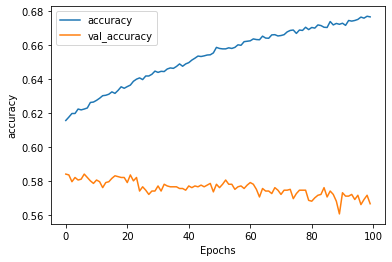

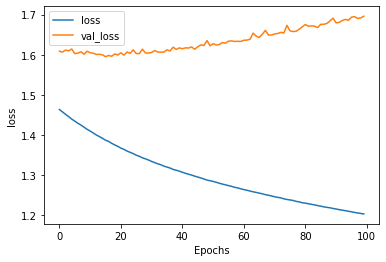

In [35]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [25]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(500, 16)


In [26]:
import io

# Create the reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [29]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')